# Bayesian Inference in Visual-SB2 Systems
### Information and Decision Systems Group<br>University of Chile

Example of Bayesian inference in visual-SB2 systems.

In [1]:
import sys
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm.notebook import tqdm
from cmdstanpy import CmdStanModel
sys.path.append( '../src' )
from utils import read_in3, getOrbit, getRV

## 1. Observations

In [2]:
system = 'HIP111170'

### 1.1. Data Parsing

In [3]:
df_as, df_v1, df_v2, df_priors = read_in3('./data/{}.in3'.format(system))
print('Astrometric observations:')
display(df_as)
print('V1 observations:')
display(df_v1)
print('V2 observations:')
display(df_v2)

Astrometric observations:


,epoch,X,Y,X_err,Y_err
0,1985.5150,-0.008534,-0.095620,0.009,0.009
1,1988.6660,-0.026764,-0.085928,0.009,0.009
2,1989.9350,-0.031234,0.037755,0.009,0.009
3,2000.8730,-0.022885,-0.086007,0.002,0.002
4,2001.7520,0.011826,0.030808,0.006,0.006
5,2002.7990,-0.008105,-0.092646,0.004,0.004
6,2014.7630,-0.018832,-0.082888,0.003,0.003
7,2014.8560,-0.017115,-0.081216,0.003,0.003
8,2015.7380,0.002617,0.049931,0.003,0.003
9,2016.3900,-0.025165,-0.076992,0.003,0.003


V1 observations:


,epoch,RV,err
0,1964.713460,-3.40,1.11
1,1965.426138,-19.60,1.11
2,1965.461457,-23.20,1.11
3,1965.483360,-23.30,1.11
4,1965.969887,-10.60,1.11
...,...,...,...
134,1986.808229,-4.31,1.11
135,1986.896932,-4.00,1.11
136,1986.928374,-2.82,1.11
137,1987.944273,-24.76,1.11


V2 observations:


,epoch,RV,err
0,1981.694929,-21.48,2.9
1,1981.820766,-22.90,2.9
2,1982.434364,-13.01,2.9
3,1982.893969,13.60,2.9
4,1983.752832,-21.78,2.9
5,1983.781191,-23.20,2.9
6,1984.577542,18.54,2.9
7,1984.648618,8.09,2.9
8,1984.735829,0.12,2.9
9,1984.741247,-3.76,2.9


### 1.2. Data Visualization

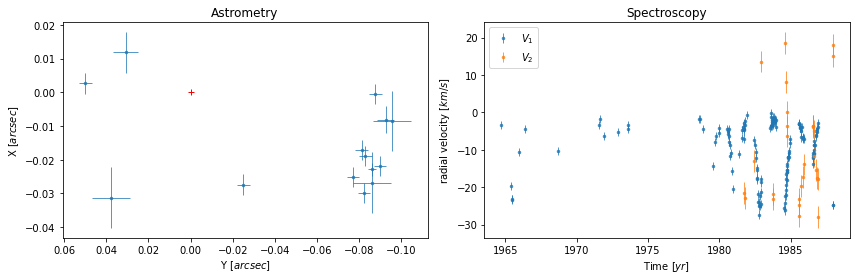

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.errorbar(df_as.Y, df_as.X, xerr=df_as.Y_err, yerr=df_as.X_err, fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.plot([0],[0],'+',color='r')
plt.xlabel(r'Y $[arcsec]$')
plt.ylabel(r'X $[arcsec]$')
plt.gca().invert_xaxis()
plt.title('Astrometry')
plt.subplot(1,2,2)
plt.errorbar(df_v1.epoch, df_v1.RV, yerr=df_v1.err, label=r'$V_1$', fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.errorbar(df_v2.epoch, df_v2.RV, yerr=df_v2.err, label=r'$V_2$', fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.ylabel(r'radial velocity [$km/s$]')
plt.xlabel('Time [$yr$]')
plt.title('Spectroscopy')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Bayesian Inference

### 2.1. Statistical Model

In [5]:
model = CmdStanModel(stan_file='../src/visual_sb2.stan', user_header='../src/kepler_eq.hpp')
print(model.code())

INFO:cmdstanpy:found newer exe file, not recompiling


functions {
    real kepler_eq(real M, real e);
    vector[] orbit(int N, vector t, real T, real P, real e, real a, real w, real Omega, real i) {
        // Variables declaration
        real M; real A; real B; real F; real G;
        vector[N] E; vector[N] x; vector[N] y; vector[N] pos[2];
        // Iterate over epochs
        for (j in 1:N) {
            // Mean anomaly
            M = 2 * pi() * (t[j] - T) / P;
            // Eccentric anomaly
            E[j] = kepler_eq(M, e);
        }
        // Auxiliary normalized coordinates
        x = cos(E) - e;
        y = sin(E) * sqrt(1 - e^2);
        // Thiele-Innes constants
        A = a * (cos(w) * cos(Omega) - sin(w) * sin(Omega) * cos(i));
        B = a * (cos(w) * sin(Omega) + sin(w) * cos(Omega) * cos(i));
        F = a * (-sin(w) * cos(Omega) - cos(w) * sin(Omega) * cos(i));
        G = a * (-sin(w) * sin(Omega) + cos(w) * cos(Omega) * cos(i));
        // Apparent orbit
        pos[1] = A * x + F * y;
        pos[2] = B * x +

In [6]:
# Orbital data
orbital_data = dict(N_as=len(df_as), 
                    N_v1=len(df_v1),
                    N_v2=len(df_v2),
                    t_as=df_as.epoch.tolist(),
                    t_v1=df_v1.epoch.tolist(),
                    t_v2=df_v2.epoch.tolist(),
                    x_obs=df_as.X.tolist(),
                    y_obs=df_as.Y.tolist(),
                    x_err=df_as.X_err.tolist(),
                    y_err=df_as.Y_err.tolist(),
                    v1_obs=df_v1.RV.tolist(),
                    v1_err=df_v1.err.tolist(),
                    v2_obs=df_v2.RV.tolist(),
                    v2_err=df_v2.err.tolist())

### 2.2. Optimization Stage

In [7]:
# Initial guesses
V_mean = np.array(df_v1.RV.tolist() + df_v2.RV.tolist()).mean()
def init_func():
    return dict(T0=np.random.uniform(0, 1), 
                log_P=np.log(632.606 / 365.25), # Providing a previous estimate of P is highly recommended 
                                                # (e.g., from sb9 or orb6 catalogues).
                e=np.random.uniform(0, 1), 
                a=np.random.uniform(0, 1),
                w=np.random.uniform(0, 2*np.pi),
                Omega=np.random.uniform(0, 2*np.pi),
                i=np.random.uniform(0, np.pi),
                V0=np.random.uniform(V_mean-10, V_mean+10),
                plx=np.random.uniform(0, 10),
                q=np.random.uniform(0, 1))

# Maximum likelihood estimation
best_mle = dict(lp__=-np.inf)
for _ in tqdm(range(1000)):
    mle = model.optimize(data=orbital_data, inits=init_func(), require_converged=False).optimized_params_dict
    if mle['lp__'] > best_mle['lp__']:
        best_mle = mle
        print("Current maximum log-probability: {0:.4f}".format(best_mle['lp__']))

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing


Current maximum log-probability: -3348.2100


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/3lj8uie3.json
init = /tmp/tmp_y8fbjiz/czwpr7ml.json
random
  seed = 78440
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021013.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -560363
    Iter     

Current maximum log-probability: -774.4120


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/aqgijbgy.json
init = /tmp/tmp_y8fbjiz/zlwti5gw.json
random
  seed = 58479
output
  file = 

Current maximum log-probability: -773.6370


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/o8wjinet.json
init = /tmp/tmp_y8fbjiz/3fl7xf05.json
random
  seed = 8418
output
  file = /

Current maximum log-probability: -115.4990


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/oemqfffs.json
init = /tmp/tmp_y8fbjiz/mjblndp8.json
random
  seed = 7973
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021017

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

Current maximum log-probability: -115.4970


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO

Current maximum log-probability: -115.4950


INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/qhvob9hp.json
init = /tmp/tmp_y8fbjiz/v2mtu4aw.json
random
  seed = 90342
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021020.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -438005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exce

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/yz0isre2.json
init = /tmp/tmp_y8fbjiz/q_giip_g.json
random
  seed = 64794
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021022.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -54325.9
    Iter    

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/bddqqkst.json
init = /tmp/tmp_y8fbjiz/r1l371bq.json
random
  seed = 4456
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021025

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/1f2pytpw.json
init = /tmp/tmp_y8fbjiz/41i3a167.json
random
  seed = 33215
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-2022021202102

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO


method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/8lgncm8z.json
init = /tmp/tmp_y8fbjiz/wp7ycwim.json
random
  seed = 52658
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021031.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -283906
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -283906             0        748409      0.0005       0.001       31   
Error evaluating model log probability:

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/as4qhx9l.json
init = /tmp/tmp_y8fbjiz/1m4hy0hu.json
random
  seed = 96313
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021032.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -9775.99
    Iter      log prob        ||dx||      ||grad||   

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/mix3jg90.json
init = /tmp/tmp_y8fbjiz/odot66ag.json
random
  seed = 65214
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021034.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

metho

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/n6dlk0yy.json
init = /tmp/tmp_y8fbjiz/lzkdzpco.json
random
  seed = 41137
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021039.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -530853
    Iter      log prob        ||dx||      ||grad||    

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/qte5nunz.json
init = /tmp/tmp_y8fbjiz/_prj5z6n.json
random
  seed = 40828
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021040.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Def

INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/audvrz7k.json
init = /tmp/tmp_y8fbjiz/ml7oewnv.json
random
  seed = 55220
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021041.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -479147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exce

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/fy_mq__9.json
init = /tmp/tmp_y8fbjiz/1ilq8fi0.json
random
  seed = 76255
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021042.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -314156
    Iter      log prob        ||dx||      ||grad||    

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/ja0r_nt

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO


method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/x25o3rki.json
init = /tmp/tmp_y8fbjiz/l64tjbe3.json
random
  seed = 38278
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021044.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -57048.1
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/home/miguel/Desktop/BinaryStars/src/visual_s

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_al

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/0ka2uq3v.json
init = /tmp/tmp_y8fbjiz/ppywpah1.json
random
  seed = 15285
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021046.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -7718.6
    Iter      log prob        ||dx||      ||grad||    

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        to

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/9w6ykbf8.json
init = /tmp/tmp_y8fbjiz/fj5gsp8p.json
random
  seed = 78564
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021048.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -9625.79
    Iter      log prob        ||dx||      ||grad||   

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/68_6rxxt.json
init = /tmp/tmp_y8fbjiz/unjmie67.json
random
  seed = 95957
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021049.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -621339
    Iter      log prob        ||dx||      ||grad||    

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/4d9orm73.json
init = /tmp/tmp_y8fbjiz/8omh8ura.json
random
  seed = 50734
output
  file = /tmp/tmp_y8fbjiz/visual_sb2-20220212021053.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmp_y8fbjiz/0ju24s8m.json
init = /tmp/tmp_y8fbjiz/f6kj1si7.j

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [8]:
best_mle

OrderedDict([('lp__', -115.495),
             ('T0', 0.436583),
             ('log_P', 0.548921),
             ('e', 0.366363),
             ('a', 0.0673969),
             ('w', 3.00012),
             ('Omega', 4.57228),
             ('i', 1.16166),
             ('V0', -9.56451),
             ('plx', 0.0358877),
             ('q', 0.534383),
             ('P', 1.73138),
             ('w_deg', 171.894),
             ('Omega_deg', 261.973),
             ('i_deg', 66.5583),
             ('T', 1965.47),
             ('m1', 1.44),
             ('m2', 0.769512),
             ('plx_mas', 35.8877),
             ('f_plx', 9.7045)])

### 2.3. Inference Stage

In [9]:
# MCMC Sampling
fit = model.sample(data=orbital_data, iter_warmup=2500, iter_sampling=2500, inits=best_mle)
fit.summary()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-130.000,0.033000,2.20000,-130.000,-130.000,-130.000,4300.0,49.0,1.0
T0,0.440,0.000073,0.00550,0.430,0.440,0.450,5700.0,64.0,1.0
log_P,0.550,0.000003,0.00031,0.550,0.550,0.550,9400.0,110.0,1.0
e,0.370,0.000120,0.01000,0.350,0.370,0.380,7300.0,82.0,1.0
a,0.067,0.000011,0.00092,0.066,0.067,0.069,6700.0,75.0,1.0
w,3.000,0.000390,0.03100,2.900,3.000,3.100,6200.0,70.0,1.0
Omega,4.600,0.000230,0.01800,4.500,4.600,4.600,6000.0,67.0,1.0
i,1.200,0.000470,0.03800,1.100,1.200,1.200,6800.0,76.0,1.0
V0,-9.600,0.000950,0.09400,-9.700,-9.600,-9.400,9800.0,110.0,1.0


## 3. Results

### 3.1. Variables Selection

In [10]:
df = fit.draws_pd()[['P', 'T', 'e', 'a', 'w_deg', 'Omega_deg', 'i_deg', 'V0', 'plx_mas', 'm1', 'm2', 'q', 'lp__']]
# ------------Temporary!!!---------------
df['T'] = fit.draws_pd(vars=['T0']).to_numpy() * fit.draws_pd(vars=['P']).to_numpy() + np.min(df_as.epoch.tolist() + df_v1.epoch.tolist() + df_v2.epoch.tolist())
# ---------------------------------------
df.columns = [r'$P$ $[yr]$', r'$T$ $[yr]$', r'$e$', r'$a$ $[″]$', r'$\omega$ $[°]$',r'$\Omega$ $[°]$',
              r'$i$ $[°]$', r'$V_{0}$ $[km/s]$', r'$\pi$ $[mas]$', r'$m_1$ $[M_\odot]$', r'$m_2$ $[M_\odot]$', 
              r'$q$', 'lp__']
df

,$P$ $[yr]$,$T$ $[yr]$,$e$,$a$ $[″]$,$\omega$ $[°]$,$\Omega$ $[°]$,$i$ $[°]$,$V_{0}$ $[km/s]$,$\pi$ $[mas]$,$m_1$ $[M_\odot]$,$m_2$ $[M_\odot]$,$q$,lp__
0,1.73075,1965.486815,0.380616,0.067285,173.907,261.737,63.3471,-9.61419,33.7076,1.75323,0.902011,0.514484,-132.473
1,1.73225,1965.454825,0.361471,0.069564,171.610,262.093,66.9462,-9.60446,38.6026,1.23887,0.711306,0.574155,-131.849
2,1.73251,1965.453105,0.360488,0.069322,171.549,262.689,68.3276,-9.60508,38.9277,1.19453,0.686927,0.575062,-131.643
3,1.73092,1965.473353,0.375207,0.067058,170.173,261.920,67.6950,-9.52311,37.4419,1.21962,0.697796,0.572142,-129.360
4,1.73185,1965.462794,0.375801,0.066905,172.875,261.724,68.1184,-9.50970,36.8188,1.28379,0.716740,0.558301,-129.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.73152,1965.475159,0.363165,0.066019,173.571,261.964,67.1390,-9.65383,35.7648,1.33415,0.763753,0.572465,-132.648
9996,1.73203,1965.474973,0.381763,0.066494,174.699,260.878,65.0660,-9.48033,34.3764,1.60317,0.809315,0.504823,-132.419
9997,1.73071,1965.478020,0.387588,0.063914,172.177,262.327,63.9678,-9.63174,35.0257,1.29228,0.736291,0.569763,-136.311
9998,1.73090,1965.452302,0.361728,0.068909,166.855,262.547,67.9958,-9.69188,39.0231,1.15714,0.680716,0.588276,-134.459


### 3.2. Point Estimates

In [11]:
# Samples
samples = df.drop(columns=['lp__']).to_numpy()
# MAP sample
map_sample = samples[df[['lp__']].to_numpy().argmax()]
# Uncertainty quantification
#lb = np.quantile(samples, 0.25, axis=0) # Quantile 1
#ub = np.quantile(samples, 0.75, axis=0) # Quantile 3
lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower
ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper

/tmp/ipykernel_14163/762135287.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower
/tmp/ipykernel_14163/762135287.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper


In [12]:
# Summary table
summary_table = [[df.columns[i], 
                  r'${:.3f}_{{{:.3f}}}^{{{:.3f}}}$'.format(map_sample[i], lb[i], ub[i])] for i in range(len(map_sample))]
df_summary = pd.DataFrame(summary_table, columns=['Parameter', 'Estimate'])
df_summary

,Parameter,Estimate
0,$P$ $[yr]$,$1.732_{1.730}^{1.732}$
1,$T$ $[yr]$,$1965.464_{1965.451}^{1965.488}$
2,$e$,$0.370_{0.346}^{0.385}$
3,$a$ $[″]$,$0.067_{0.066}^{0.069}$
4,$\omega$ $[°]$,$171.186_{168.317}^{175.210}$
5,$\Omega$ $[°]$,$261.814_{260.047}^{263.957}$
6,$i$ $[°]$,$67.219_{62.145}^{70.757}$
7,$V_{0}$ $[km/s]$,$-9.523_{-9.743}^{-9.374}$
8,$\pi$ $[mas]$,$35.847_{33.529}^{38.519}$
9,$m_1$ $[M_\odot]$,$1.451_{1.139}^{1.732}$


## 4. Visualization

### 4.1. Marginal Posterior Distributions

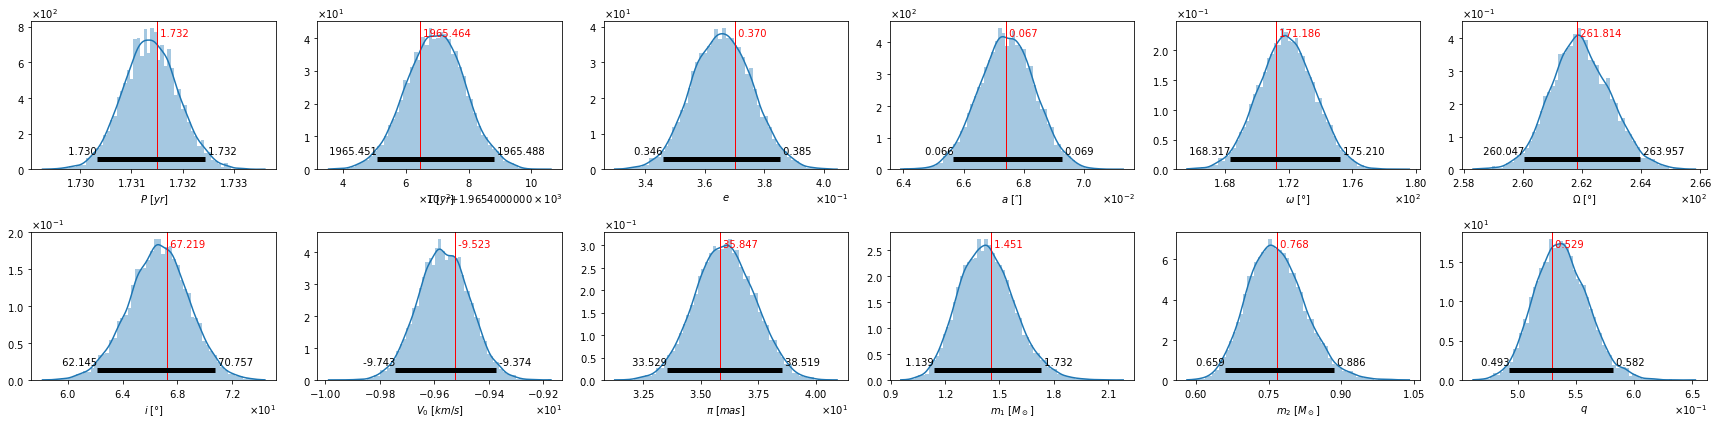

In [13]:
params_names = df.drop(columns=['lp__']).columns.tolist()
plt.figure(figsize=(24,6))
for i in range(samples.shape[1]):
    plt.subplot(2,6,i+1)
    sns.histplot(samples[:,i], stat='density', kde=True, color='tab:blue', alpha=0.4, **{"edgecolor": None})
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(map_sample[i], color='red', linewidth=1)
    plt.text(map_sample[i], max_ylim * 0.9, ' {:.3f}'.format(map_sample[i]), color='red')
    plt.hlines(y=max_ylim * 0.07, xmin=lb[i], xmax=ub[i], linewidth=5, color='black')
    plt.text(lb[i], max_ylim * 0.1, ' {:.3f}'.format(lb[i]), color='black', horizontalalignment='right') 
    plt.text(ub[i], max_ylim * 0.1, ' {:.3f}'.format(ub[i]), color='black') 
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel(params_names[i])
    plt.ylabel(None) 
plt.tight_layout()
plt.show()

### 4.2. Pair Posterior Distributions

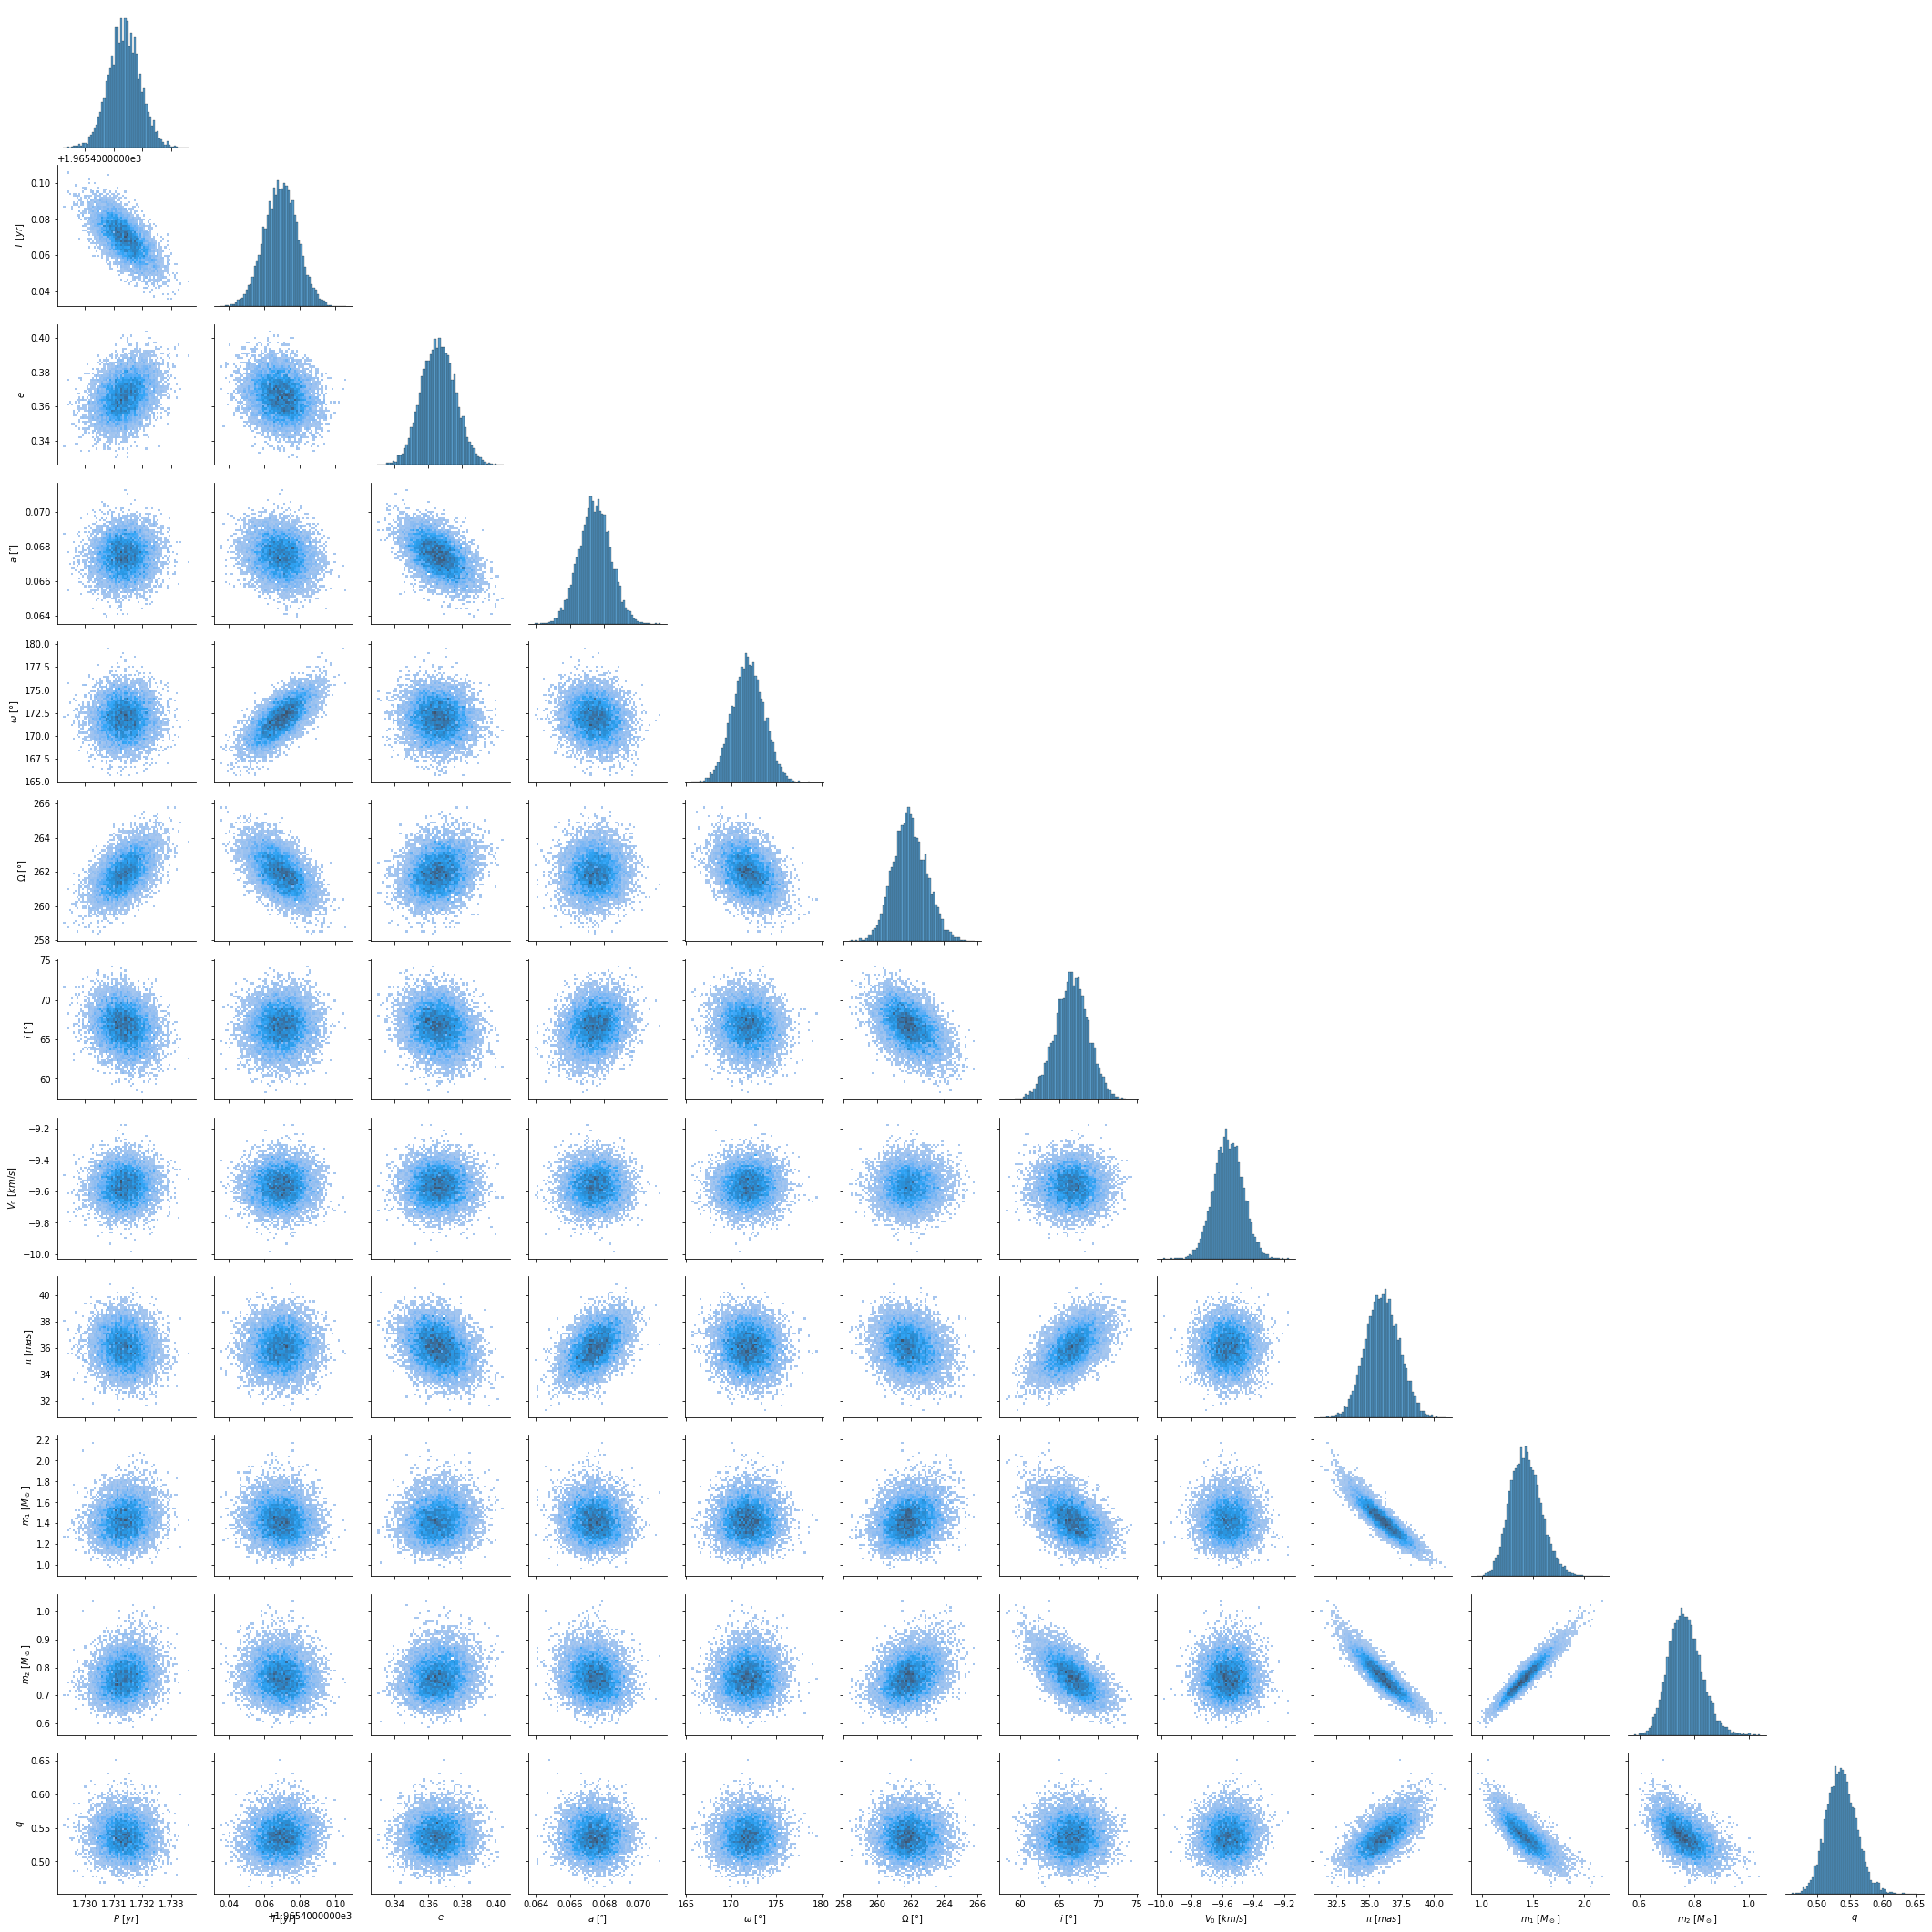

In [14]:
sns.pairplot(df.drop(columns='lp__'), kind='hist', corner=True)
plt.show()

### 4.3. Orbit & Radial Velocity Curve

In [15]:
# Aesthetics utils
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greys_r')
cmap_p = plt.get_cmap('Blues_r')
cmap_s = plt.get_cmap('Reds_r')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

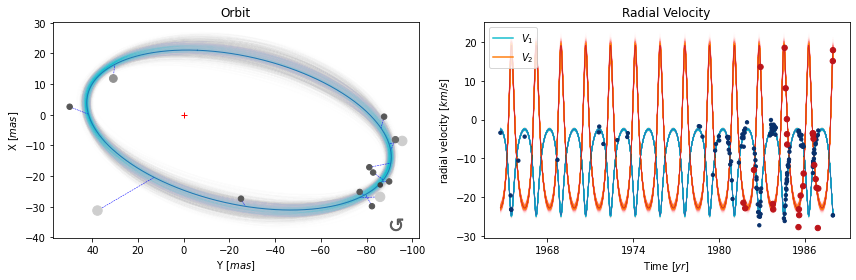

In [17]:
### Orbit & RV
plt.figure(figsize=(12,4))
rnd_idx = np.random.choice(samples.shape[0], 1000, replace=False)

### Orbit plot
plt.subplot(1, 2, 1)
# Orbit samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = samples[rnd_idx[j]]
    t = np.linspace(0, P, 1000)
    X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
    plt.plot(Y * 1000, X * 1000, color='tab:cyan', alpha=0.005)
# MAP orbit
P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = map_sample
t = np.linspace(0, P, 1000)
X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
# Data projection on the MAP orbit
Xorb, Yorb = getOrbit(df_as.epoch.to_numpy(), T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
plt.plot(Y * 1000, X * 1000, color='tab:blue', linewidth=1, zorder=j)
for k in range(len(df_as)):
    plt.plot([df_as.Y[k]  * 1000, Yorb[k] * 1000], [df_as.X[k] * 1000, Xorb[k] * 1000], '--', color='blue', linewidth=0.5)
# Dataset
plt.scatter(df_as.Y * 1000, df_as.X * 1000, s=df_as.X_err * 10000, c=df_as.X_err, cmap=truncate_colormap(cmap, 0.2, 0.7), zorder=2000)
plt.plot([0], [0], '+', color='r')
legend = plt.gca().get_legend()
plt.xlabel(r'Y $[mas]$')
plt.ylabel(r'X $[mas]$')
plt.title('Orbit')
plt.gca().invert_xaxis()
# Orientation symbol: marker={r'$\circlearrowleft$', r'$\circlearrowright$'}
plt.plot([0.9 * plt.xlim()[1]],[0.9 * plt.ylim()[0]], marker=r'$\circlearrowleft$',ms=15, mew=0.5, color='black', alpha=0.6)

### RV plot
plt.subplot(1, 2, 2)
t = np.linspace(min(df_v1.epoch.min(), df_v2.epoch.min()), max(df_v1.epoch.max(), df_v2.epoch.max()), 3000)
# RV samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = samples[rnd_idx[j]]
    V1, V2 = getRV(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, plx * 0.001, q)
    plt.plot(t, V1, color='tab:cyan', alpha=0.005)
    plt.plot(t, V2, color='tab:orange', alpha=0.005)
plt.plot([], [], color='tab:cyan', label=r'$V_1$')
plt.plot([], [], color='tab:orange', label=r'$V_2$')
# MAP RV
P, T, e, a, w, Omega, i, V0, plx, m1, m2, q = map_sample
V1, V2 = getRV(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, plx * 0.001, q)
plt.plot(t, V1, linewidth=1, color='tab:blue')
plt.plot(t, V2, linewidth=1, color='tab:red')  
plt.scatter(df_v1.epoch, df_v1.RV, s=df_v1.err * 10, c=df_v1.err, cmap=truncate_colormap(cmap_p, 0, 0.3), zorder=3)
plt.scatter(df_v2.epoch, df_v2.RV, s=df_v2.err * 10, c=df_v2.err, cmap=truncate_colormap(cmap_s, 0.2, 0.5), zorder=4)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('radial velocity [$km/s$]')
plt.xlabel('Time $[yr]$')
plt.legend(loc='upper left')
plt.title('Radial Velocity')
plt.tight_layout()
plt.show()